# Digit Recognizer

- The goal of the project is to correctly predict the digits from pixel values of images.  

- In this notebook, I tested:

> **RandomForest** submission achieve **0.98496** in the leaderboard **(top 47%)**


> **CNN** submission achieve **0.99339** in the leaderboard **(top 17%)**


> **Ensemble 11 CNNs** submission achieve **0.99517** in the leaderboard **(top 8%)**



The CNN model achieve amazing result close to human!!!

<br>



<br>

**Best results : 99.517 % accuracy (Top 8%)**


### Workflow stages:


##### 1) Import data

##### 2) Data exploration

##### 3) Feature engineering 

##### 4) Modeling - ML models

##### 5) Modeling - CNN with data augmentation

##### 6) Modeling - Ensemble of 11 CNN


# 1) Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random



# sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


In [2]:
# Our datasets
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

dfs = [('train',df_train), ('test',df_test)]

# 2) Data exploration

### Presentation

In [3]:
for df in dfs:
  print(df[0],':\n\nShape:', df[1].shape,'\n')
  print(df[1].info(),'\n\n\n')

train :

Shape: (42000, 785) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None 



test :

Shape: (28000, 784) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None 





Each row represents 784 pixels of an image.

The training set has one additional column _label_. 

The label is the number represented by the image, our target variable.

In [4]:
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Nan Values

In [5]:
for df in dfs:
  print(df[0], 'nb of nan:',sum(df[1].isna().sum(axis = 0)),'\n')

train nb of nan: 0 

test nb of nan: 0 



### Data types

In [6]:
if (df_train.dtypes == 'int64').all():
  print('Our entire dataframe is made up of integers')

Our entire dataframe is made up of integers


### Target

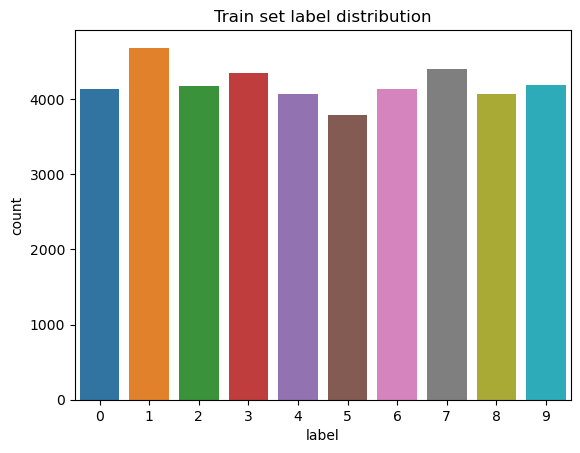

In [7]:
sns.countplot(x = 'label',  data = df_train)
plt.title('Train set label distribution')
plt.show()

We have a balance training set

### Pixel columns

In [8]:
print('Minimum pixel value: ', min(df_train.min()))
print('Maximum pixel value: ',max(df_train.max()))

Minimum pixel value:  0
Maximum pixel value:  255


# 3) Data preparation

### Plot image

Each image contain 784 pixel, we will reshape it in 28\*28 format (28\*28 =784) to have a square image.

In [9]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


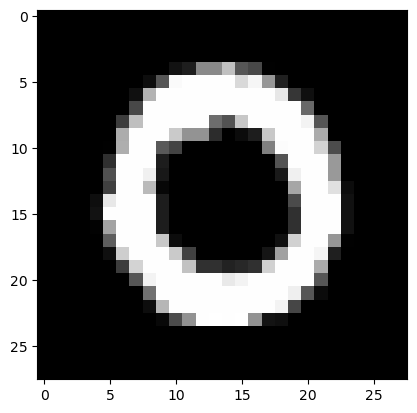

In [10]:
plt.imshow(df_train.iloc[1,1:].values.reshape(28,28),cmap="gray")
plt.show()

### Pixels meaning

0: black

255: white

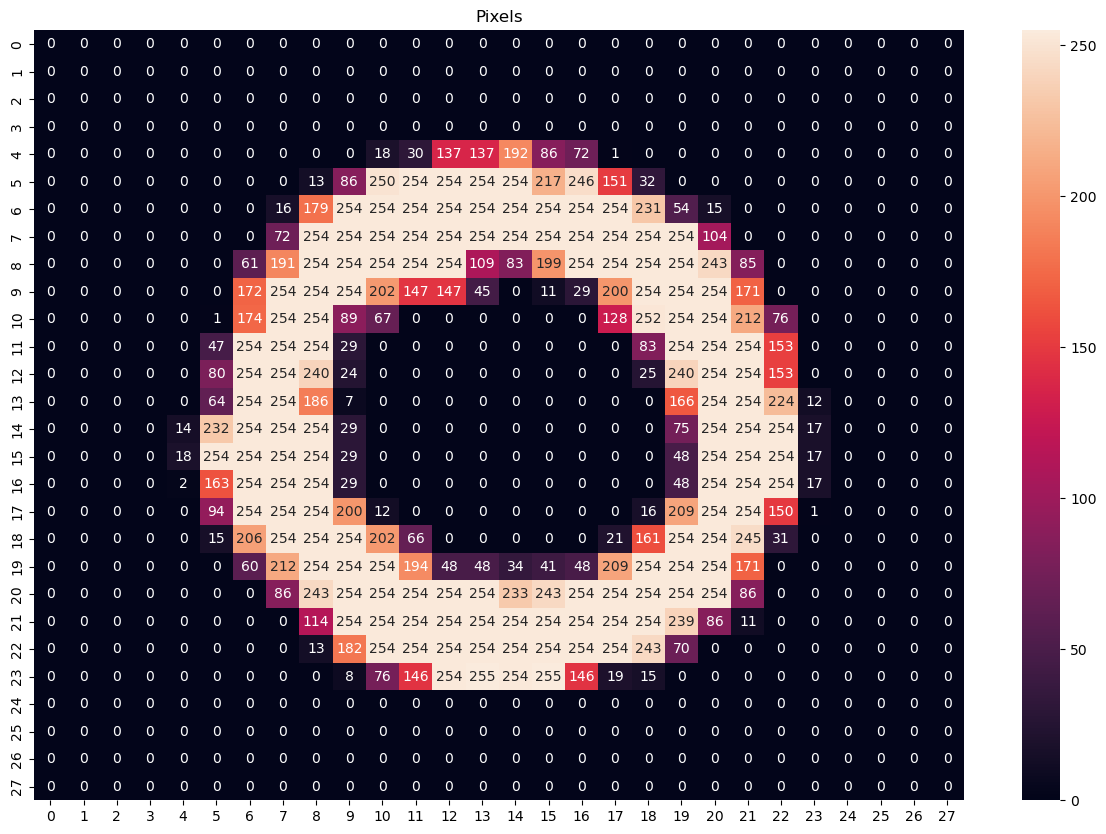

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(df_train.iloc[1,1:].values.reshape(28,28), annot=True, fmt='.0f')
plt.title('Pixels')
plt.show()

### Pixels Normalization [0;1]

We will scale our pixel values btw [0;1].

> Why?

We plan to use an NN to predict the image label. In order to avoid an unstable gradient, we prefer a small input range. _(converge faster)_


For example, a large scale could produce large gradient during backpropagation  and difficulties in updating the model with relevant weights. 


We will test also:

- RandomForest model, normalization doesn't impact the performance of the model.

- BernouilliClassifier, normalization will allow an easier binarization of the pixels.




In [12]:
# Normalize the data
# Avoid unstable gradient
# Converge faster

X = df_train.drop('label', axis = 1)
y = df_train['label']



X = X / 255.0
df_test = df_test / 255.0

# 4) Modeling - ML models

- RandomForestClassifier
- BernouilliClassifier

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [14]:
def report(clf, X_train = X_train, y_train = y_train,X_test = X_test ,y_test = y_test ):

  # get the start time
  st = time.time()

  clf.fit(X_train,y_train)

  y_pred = clf.predict(X_test)

  print(classification_report(y_test, y_pred))

  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
  plt.title('Classification Report')
  plt.show()

  print('Execution time:', round(time.time() - st,2) , 'seconds')

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       408
           1       0.99      0.99      0.99       471
           2       0.96      0.96      0.96       420
           3       0.96      0.94      0.95       506
           4       0.96      0.96      0.96       397
           5       0.96      0.96      0.96       339
           6       0.97      0.98      0.98       402
           7       0.96      0.96      0.96       438
           8       0.94      0.95      0.95       403
           9       0.94      0.94      0.94       416

    accuracy                           0.96      4200
   macro avg       0.96      0.96      0.96      4200
weighted avg       0.96      0.96      0.96      4200



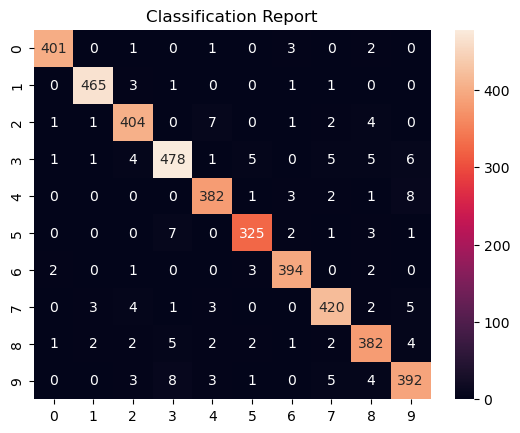

Execution time: 24.7 seconds


In [15]:
report(RandomForestClassifier(random_state=0))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       408
           1       0.89      0.96      0.92       471
           2       0.86      0.83      0.85       420
           3       0.79      0.78      0.79       506
           4       0.79      0.80      0.79       397
           5       0.78      0.70      0.73       339
           6       0.89      0.88      0.89       402
           7       0.92      0.84      0.88       438
           8       0.74      0.77      0.75       403
           9       0.72      0.79      0.75       416

    accuracy                           0.83      4200
   macro avg       0.83      0.82      0.82      4200
weighted avg       0.83      0.83      0.83      4200



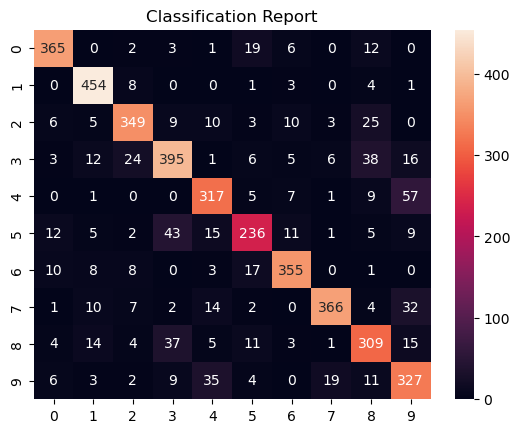

Execution time: 1.31 seconds


In [16]:
report(BernoulliNB())

RandomForest submission achieve 0.98496 in the leaderboard (top 47%)



# 5) Modeling - CNN with data augmentation

### Reshape data

In [17]:
# OHE target 
# model output vector with estimated probabilities of each class 
# we train it with OHE target (1 on the target index, 0 otherwise)
y = pd.get_dummies(df_train['label']).values

In [18]:
X.shape

(42000, 784)

In [19]:
# Reshape each image to 3D matrix 28*28 with 1 chanel (no colors)
X = X.values.reshape(-1,28,28,1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

### Data augmentation 


We will expand the size of the dataset by applying any random transformations on each training image as it is passed to the model. New images will not be add to the original corpus of images.


> It will prevent from overfitting and create a more robust model without compromising memory.

In [21]:
# Real-time data augmentation without saving during training (NN)
datagen = ImageDataGenerator(
        rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally 
        height_shift_range=0.1)  # randomly shift images vertically 

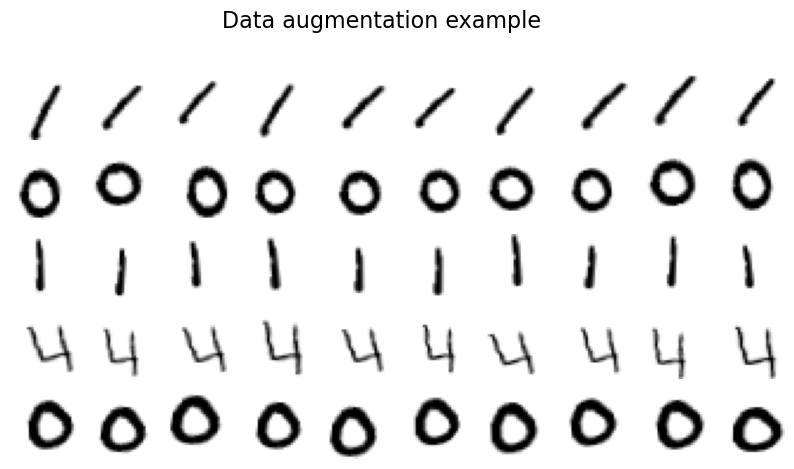

In [22]:
plt.figure(figsize=(10,5))

for r in range(5):
  X_item = X[r].reshape((1,28,28,1))

  for i in range(10):    
      plt.subplot(5, 10, 10*r + i+1)
      new_X_item = datagen.flow(X_item).next()
      plt.imshow(new_X_item[0].reshape((28,28)),cmap=plt.cm.binary)    
      plt.axis('off') 

plt.suptitle('Data augmentation example \n', fontsize=16,y=1.01)

plt.show()

### CNN  - Model 


The model is from [Yassine Ghouzam - Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook)

<br>

In order to have faster training:

- Stop training if the accuracy is not improved after 10 epochs and keep the best model

- Use RMSprop optimizer (adaptive learning rates)

- Reduce the learning rates by half if the accuracy is not improved after 3 epochs

<br>

**Why do we use annealing method of the learning rates with an adaptive learning optimizer?**

"every parameter in the network has a specific learning rate associated"

"Without decay, you have to set a very small learning rate so the loss won't begin to diverge after decrease to a point."




[Source](https://stackoverflow.com/questions/39517431/should-we-do-learning-rate-decay-for-adam-optimizer)





In [23]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# stop training if no progress after 10 epochs and keep the best model to accelerate training
early_stopping_cb = keras.callbacks.EarlyStopping(patience =10, restore_best_weights =True)

# reduce the LR by half if the accuracy is not improved after 3 epochs in validation set
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)


# Fit the model
history = model.fit(datagen.flow(X_train,y_train, batch_size=64),
                              epochs = 30, validation_data = (X_test,y_test),
                              steps_per_epoch=X_train.shape[0] // 64
                              , callbacks=[early_stopping_cb, reduce_lr])


Epoch 1/30


2023-04-04 16:00:29.860957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 20s 22ms/step - loss: 0.3818 - accuracy: 0.8782 - val_loss: 0.0605 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 12s 21ms/step - loss: 0.1254 - accuracy: 0.9629 - val_loss: 0.0402 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 13s 21ms/step - loss: 0.0939 - accuracy: 0.9718 - val_loss: 0.0428 - val_accuracy: 0.9864 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0840 - accuracy: 0.9751 - val_loss: 0.0335 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0775 - accuracy: 0.9781 - val_loss: 0.0358 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 13s 21ms/step - loss: 0.0704 - accuracy: 0.9796 - val_loss: 0.0427 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 13s 21ms/step -

### Evaluate the model

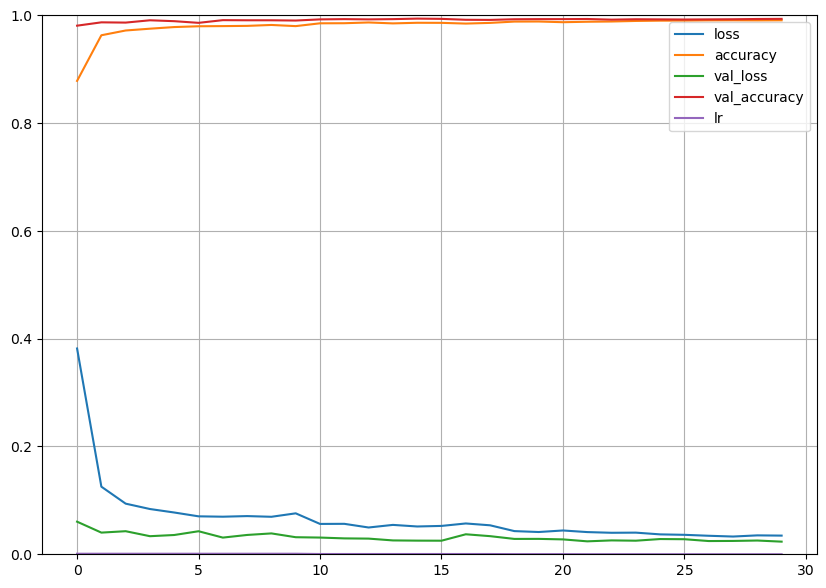

132/132 [==============================] - 0s 2ms/step


               precision    recall  f1-score   support

           0       1.00      0.99      0.99       408
           1       1.00      0.99      0.99       471
           2       1.00      0.99      0.99       420
           3       0.99      1.00      1.00       506
           4       1.00      0.99      0.99       397
           5       0.99      0.98      0.99       339
           6       0.99      1.00      0.99       402
           7       0.99      1.00      0.99       438
           8       0.99      1.00      0.99       403
           9       0.99      1.00      0.99       416

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200
 




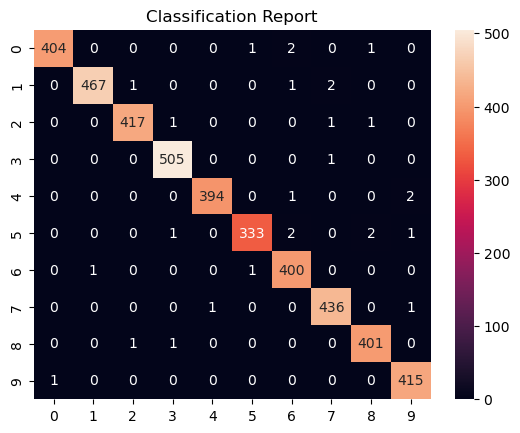

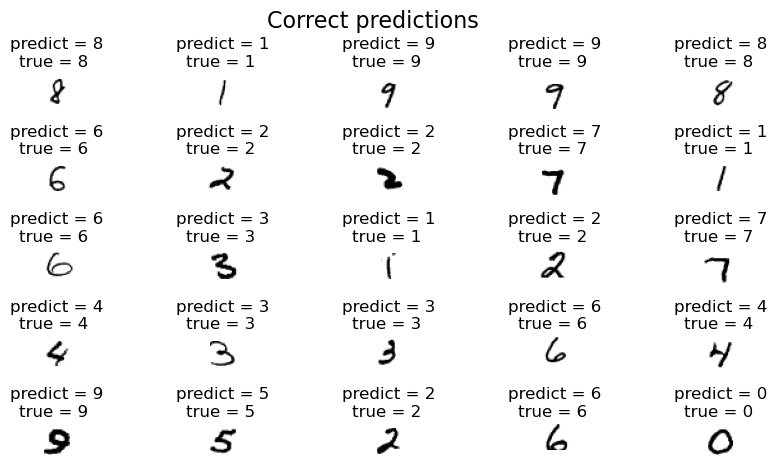

In [24]:
# plot loss and accuracy curves for training and validation 
pd.DataFrame(history.history).plot(figsize = (10,7))
plt.grid(True)
plt.ylim(0,1)
plt.show()


# reshape data to 1D
y_pred_10_D = model.predict(X_test)
y_pred_1D = np.argmax(y_pred_10_D,axis = 1)
y_test_1D = np.argmax(y_test,axis = 1)

# classification report
print('\n\n',classification_report(y_test_1D , y_pred_1D), '\n\n')

# confusion matrix
sns.heatmap(confusion_matrix(y_test_1D , y_pred_1D), annot=True, fmt='d')
plt.title('Classification Report')
plt.show()

print('\n\n')

# plot digits
t = y_test_1D == y_pred_1D
good_pred = np.where(t==True)

solutions = []

plt.figure(figsize=(10,5))

j = 1
for i in good_pred[0][:25]:    
    plt.subplot(5, 5, j)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary) 
    
    solutions.append(y_test_1D[i])
    
    plt.title("predict = {}\ntrue = {} ".format(y_pred_1D[i], y_test_1D[i]))
    plt.axis('off')      
    j+=1

    plt.subplots_adjust(wspace= 0.5, hspace= 1.5)

plt.suptitle('Correct predictions \n', fontsize=16,y=1.01)
plt.show()

#### Prediction errors from the CNN

Guess the digits from the below pictures to see if you fail like the CNN

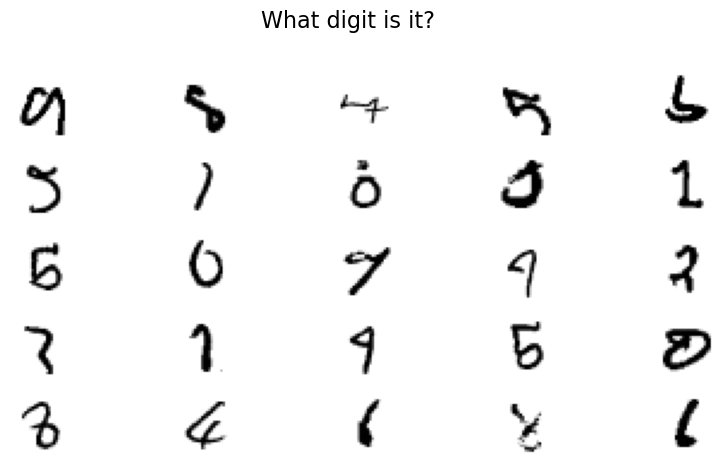

In [25]:
t = y_test_1D !=y_pred_1D
error_pred = np.where(t==True)

solutions = []
errors = []

plt.figure(figsize=(10,5))

j = 1
for i in error_pred[0][:25]:    
    plt.subplot(5, 5, j)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary) 
    
    solutions.append(y_test_1D[i])
    errors.append(y_pred_1D[i])

    
#     plt.title("predict = {}\ntrue = {} ".format(y_pred_1D[i], y_test_1D[i]))
    plt.axis('off')      
    j+=1

#     plt.subplots_adjust(wspace= 0.5, hspace= 1.5)

plt.suptitle('What digit is it? \n', fontsize=16,y=1.01)
plt.show()


**Solutions**

In [26]:
# true label
np.array(solutions).reshape(5,5)

array([[9, 5, 7, 5, 6],
       [5, 1, 0, 0, 1],
       [5, 0, 7, 4, 2],
       [3, 1, 4, 5, 0],
       [8, 4, 1, 8, 6]])

In [27]:
# error predicted label
np.array(errors).reshape(5,5)

array([[0, 8, 4, 9, 5],
       [3, 7, 6, 5, 2],
       [6, 6, 9, 9, 3],
       [7, 7, 9, 6, 8],
       [3, 6, 6, 2, 1]])

### Submission - CNN with data augmentation


In [28]:
# # predict results
# results = model.predict(df_test.values.reshape(-1,28,28,1))

# # select the index with the maximum probability
# results = np.argmax(results,axis = 1)
# results = pd.Series(results,name="Label")

# # submission
# submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
# submission.to_csv("submission.csv",index=False)

CNN submission achieve 0.99339 in the leaderboard (top 17%)


# 6) Modeling - Ensemble 11 CNNs



"A trained neural network performs differently each time you train it since the weights are randomly initialized. Therefore, to assess a neural network's performance, we must train it many times and take an average of accuracy."  [Chris Deotte - 25 Million Images! [0.99757] MNIST](https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist)


<br>

We'll take the same model as before, we'll train it 10 more times on a different train and test set, and then we'll aggregate the predictions of the 11 CNN

In [29]:
# we add our fisrt CNN into the ensemble
models = [model]

for i in range(10):
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    
    optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    models.append(model)

In [30]:
histories = [history]
i = 2
for model in models[1:]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    
    # stop training if no progress after 10 epochs and keep the best model to accelerate training
    early_stopping_cb = keras.callbacks.EarlyStopping(patience =10, restore_best_weights =True)

    # reduce the LR by half if the accuracy is not improved after 3 epochs in validation set
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                  patience=3, min_lr=0.00001)
    
    history = model.fit(datagen.flow(X_train,y_train, batch_size=64),
                              epochs = 30, validation_data = (X_test,y_test),
                              steps_per_epoch=X_train.shape[0] // 64
                              , callbacks=[early_stopping_cb, reduce_lr])
    histories.append(history)
    
    print("CNN {}: Best Train accuracy={}, Best Validation accuracy={}".format(i
        ,max(history.history['accuracy']),max(history.history['val_accuracy']) ))
    i+=1

Epoch 1/30
  4/590 [..............................] - ETA: 12s - loss: 2.3067 - accuracy: 0.1250  

2023-04-04 16:08:44.388126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 14s 21ms/step - loss: 0.3901 - accuracy: 0.8754 - val_loss: 0.0506 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 13s 22ms/step - loss: 0.1192 - accuracy: 0.9644 - val_loss: 0.0423 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0943 - accuracy: 0.9723 - val_loss: 0.0397 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0781 - accuracy: 0.9775 - val_loss: 0.0409 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 13s 21ms/step - loss: 0.0768 - accuracy: 0.9782 - val_loss: 0.0342 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 13s 23ms/step - loss: 0.0726 - accuracy: 0.9794 - val_loss: 0.0437 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 13s 23ms/step -

2023-04-04 16:16:14.097599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 15s 23ms/step - loss: 0.3915 - accuracy: 0.8769 - val_loss: 0.0647 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 13s 22ms/step - loss: 0.1271 - accuracy: 0.9621 - val_loss: 0.0463 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0949 - accuracy: 0.9720 - val_loss: 0.0415 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 23ms/step - loss: 0.0799 - accuracy: 0.9776 - val_loss: 0.0312 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 13s 23ms/step - loss: 0.0753 - accuracy: 0.9783 - val_loss: 0.0314 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 14s 24ms/step - loss: 0.0674 - accuracy: 0.9808 - val_loss: 0.0426 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 13s 22ms/step -

2023-04-04 16:22:47.606544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 14s 22ms/step - loss: 0.3726 - accuracy: 0.8816 - val_loss: 0.0476 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 14s 23ms/step - loss: 0.1224 - accuracy: 0.9649 - val_loss: 0.0300 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0928 - accuracy: 0.9721 - val_loss: 0.0246 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0791 - accuracy: 0.9772 - val_loss: 0.0287 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 13s 23ms/step - loss: 0.0728 - accuracy: 0.9792 - val_loss: 0.0316 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0698 - accuracy: 0.9803 - val_loss: 0.0261 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 13s 23ms/step -

2023-04-04 16:31:26.485766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 14s 22ms/step - loss: 0.3796 - accuracy: 0.8789 - val_loss: 0.0830 - val_accuracy: 0.9743 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 13s 21ms/step - loss: 0.1208 - accuracy: 0.9638 - val_loss: 0.0536 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 13s 23ms/step - loss: 0.0895 - accuracy: 0.9734 - val_loss: 0.0465 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0803 - accuracy: 0.9760 - val_loss: 0.0374 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0744 - accuracy: 0.9783 - val_loss: 0.0318 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 14s 23ms/step - loss: 0.0686 - accuracy: 0.9796 - val_loss: 0.0436 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 13s 22ms/step -

2023-04-04 16:39:12.195011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 15s 23ms/step - loss: 0.3699 - accuracy: 0.8801 - val_loss: 0.0501 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 13s 21ms/step - loss: 0.1178 - accuracy: 0.9655 - val_loss: 0.0428 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0921 - accuracy: 0.9736 - val_loss: 0.0343 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0764 - accuracy: 0.9776 - val_loss: 0.0309 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0723 - accuracy: 0.9797 - val_loss: 0.0369 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 13s 21ms/step - loss: 0.0715 - accuracy: 0.9792 - val_loss: 0.0442 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 13s 22ms/step -

2023-04-04 16:47:25.586976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 14s 22ms/step - loss: 0.3577 - accuracy: 0.8856 - val_loss: 0.0654 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 14s 23ms/step - loss: 0.1191 - accuracy: 0.9649 - val_loss: 0.0353 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0899 - accuracy: 0.9736 - val_loss: 0.0288 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 14s 23ms/step - loss: 0.0756 - accuracy: 0.9785 - val_loss: 0.0383 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0746 - accuracy: 0.9781 - val_loss: 0.0314 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0675 - accuracy: 0.9805 - val_loss: 0.0294 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 14s 24ms/step -

2023-04-04 16:50:46.601742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 15s 24ms/step - loss: 0.3972 - accuracy: 0.8736 - val_loss: 0.0761 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 13s 22ms/step - loss: 0.1250 - accuracy: 0.9633 - val_loss: 0.0670 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 14s 23ms/step - loss: 0.0931 - accuracy: 0.9719 - val_loss: 0.0419 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0802 - accuracy: 0.9772 - val_loss: 0.0278 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 14s 23ms/step - loss: 0.0734 - accuracy: 0.9796 - val_loss: 0.0357 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0699 - accuracy: 0.9798 - val_loss: 0.0336 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 14s 23ms/step -

2023-04-04 16:59:41.835735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 16s 25ms/step - loss: 0.3972 - accuracy: 0.8728 - val_loss: 0.1131 - val_accuracy: 0.9657 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 12s 21ms/step - loss: 0.1204 - accuracy: 0.9636 - val_loss: 0.0380 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 14s 24ms/step - loss: 0.0922 - accuracy: 0.9730 - val_loss: 0.0353 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0796 - accuracy: 0.9762 - val_loss: 0.0328 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 14s 23ms/step - loss: 0.0707 - accuracy: 0.9793 - val_loss: 0.0390 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0668 - accuracy: 0.9805 - val_loss: 0.0254 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 14s 24ms/step -

2023-04-04 17:08:40.608057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 15s 24ms/step - loss: 0.3788 - accuracy: 0.8800 - val_loss: 0.0547 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 13s 21ms/step - loss: 0.1229 - accuracy: 0.9640 - val_loss: 0.0281 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0934 - accuracy: 0.9724 - val_loss: 0.0398 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0783 - accuracy: 0.9774 - val_loss: 0.0348 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0702 - accuracy: 0.9793 - val_loss: 0.0305 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 14s 23ms/step - loss: 0.0678 - accuracy: 0.9804 - val_loss: 0.0343 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 12s 21ms/step -

2023-04-04 17:17:02.907191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


590/590 [==============================] - 15s 24ms/step - loss: 0.3950 - accuracy: 0.8731 - val_loss: 0.0965 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 2/30
590/590 [==============================] - 13s 22ms/step - loss: 0.1214 - accuracy: 0.9637 - val_loss: 0.0512 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 3/30
590/590 [==============================] - 13s 21ms/step - loss: 0.0909 - accuracy: 0.9720 - val_loss: 0.0388 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 4/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0785 - accuracy: 0.9774 - val_loss: 0.0559 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 5/30
590/590 [==============================] - 12s 21ms/step - loss: 0.0717 - accuracy: 0.9792 - val_loss: 0.0370 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 6/30
590/590 [==============================] - 13s 22ms/step - loss: 0.0706 - accuracy: 0.9796 - val_loss: 0.0347 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 7/30
590/590 [==============================] - 14s 24ms/step -

### Submission - Ensemble of 11 CNN 

In [31]:
# initialize result with 0
results = np.zeros( (df_test.shape[0],10) )

# sum vector prediction of each model
for model in models:
    results = results + model.predict(df_test.values.reshape(-1,28,28,1))

# select the index with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

# submission
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)

875/875 [==============================] - 2s 2ms/step


 Ensemble 11 CNNs submission achieve 0.99517 in the leaderboard (top 8%)


**Upvotes and comments would be very much appreciated :)**